In [1]:
from ax.modelbridge.generation_strategy import (
    GenerationStep, GenerationStrategy)
from ax import (Arm, ChoiceParameter, ComparisonOp, Data, FixedParameter,
                Metric, Models, Objective, OptimizationConfig,
                OutcomeConstraint, Parameter, ParameterType, RangeParameter,
                Runner, SearchSpace, SimpleExperiment)
import pandas as pd
import numpy as np
import hydra
import os
import json
import logging
import warnings
from ax import save
from ax.service.ax_client import AxClient
from ax.storage.runner_registry import register_runner
from bcidecode.preprocessing.data import get_alignOn, get_timesteps, load_data, split_data
from bcidecode.preprocessing.parameters import Preprocessing_DefaultParameters
from bcidecode.modeling.defaults import (CLASSIFIERS, FEATURE_EXTRACTORS,
                                       PREPROCESSORS, FILTERING_SCORERS,
                                       OUTLIER_DETECTORS, MANIFOLD_ALIGNERS)
from bcidecode.modeling.pipeline_builder import PipelineBuilder
from bcidecode.modeling.pipelines import PIPELINES, ExplorationPipeline
from omegaconf import DictConfig, OmegaConf
from bcidecode.preprocessing.ratesTransformer import RatesTransformer
from bcidecode.preprocessing.reachTuningTransformer import ReachTuningTransformer
from sklearn.model_selection import train_test_split
from tnsbmi import dataconversion
from tnsbmi.binning import Bin
from ax import load
import pickle
from bcidecode.optimization.utils import (SearchSpaceGen, get_diff_dict,
                                configure_model,
                                configure_optimization, get_default_params,
                                run_experiment)
from bcidecode.optimization.axUtils import GetBestMetrics, load_best_config

import seaborn as sns
from math import ceil
from bcidecode.plotting.utils import *
from bcidecode.plotting.plots import visualize_embeddings, components_pairplot, components_violinplot
from sklearn.base import clone

%matplotlib inline
sns.set_context("notebook")

In [2]:
def load_data_multi(data_dir_root, n_days, task_id):
    datasets = os.listdir(data_dir_root)[:n_days]

    data_dict = {}
    for dataset in datasets:
        # Get data path
        data_path = os.path.join(data_dir_root, dataset)
        # Get dataset name
        dataset_name, _ = os.path.splitext(dataset)
        dataset_name = dataset_name.split(task_id)[-1]
        # Load data
        trials, labels = load_data(data_path)
        # Fill data dict entry
        data_dict[dataset_name] = {
            "X": np.array(trials), "y": labels
        }
    return data_dict

# Parameters

In [3]:
root_dir = (
    r"C:\Users\u0142927\Desktop\NeuroscienceLeuven\Code\outputs\different_objects_multi\vgrasp_Sky_\Anova_RF\Anova_Times_CCA_RF_neg_log_loss\Default\2021-01-19_12-43-34"
)
metric = "accuracy"
k = 6
embedder = "lda"

In [4]:
# Parameters
root_dir = "C:\\Users\\u0142927\\Desktop\\NeuroscienceLeuven\\Code\\outputs/different_objects_multi/vgrasp_Sky_/Anova_RF/Anova_Times_CCA_RF_mapR/Default/2021-01-21_14-16-40"
metric = "mapR"
embedder = "lda"


# Loading Opt Results

In [5]:
opt_parameters = load_best_config(root_dir, metric)
cfg_path = os.path.join(root_dir,".hydra","config.yaml")
cfg = OmegaConf.load(cfg_path)
# Fix for old experiments
cfg.base_optimization = cfg.get('base_optimization', True)
cfg.model = cfg.get("model","basic_decoder")

[INFO 01-21 14:39:58] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 2 decimal points.


# Best Parameters

In [6]:
opt_parameters

{'preprocessing__kbest_anova__k': 36,
 'feature_extraction__factor_analysis__n_components': 2,
 'preprocessing__tuning_filter__k': 77,
 'aligner__numCC': 2,
 'aligner__reg': 2.632894571708272e-05}

# Set-Up

In [7]:
# Data loading
n_days = 2
data_dict = load_data_multi(cfg.data.root_dir, n_days, cfg.data.task_id)

In [8]:
# Setting model catalogue
available_steps = {**PREPROCESSORS, **FEATURE_EXTRACTORS, **CLASSIFIERS}
available_scorers = FILTERING_SCORERS
# Setting optimization parameters
basic_params, extended_params = configure_optimization(cfg)
# Default params
default_params = get_default_params(cfg, basic_params)
default_params['preprocessing__rates_comp__t_int'] = 700
# Define pipeline
model_pipeline = PipelineBuilder(available_steps, available_scorers)
model_pipeline = model_pipeline.fit(cfg.pipeline.pipeline_arch)

# Get model parameters
if cfg.base_optimization:
    model_params = [
        model_pipeline,
        MANIFOLD_ALIGNERS[cfg.extensions.align.manifold_aligner],
        cfg.metric_dict,
        default_params
    ]
else:
    model_params = [
        model_pipeline,
        OUTLIER_DETECTORS[cfg.extensions.outlier.outlier_detector],
        cfg.extensions.outlier.insert_stage,
        cfg.metric_dict,
        default_params
    ]

# Init model
model = configure_model(cfg, PIPELINES, *model_params)
# Add training data to model
model = model.set_data(data_dict)

In [9]:
# Fit model
single_model, common_model, aligner_model = model.define_models(opt_parameters)

# Exploration Pipeline

In [10]:
n_folds = 10
fold = 0
splits=["train","test"]
# Single model processing
single_model, common_model, aligner_model = model.define_models(opt_parameters)
cv_dict = model.get_cv_dict(model.data_dict, n_folds)
# # Data Set-up
data = model.get_fold_dict(cv_dict, fold, splits)

In [11]:
pipeline_arch = cfg.pipeline.pipeline_arch
step = get_step_name(pipeline_arch, "preprocessing", "kbest")

In [12]:
preprocessing_dfs=[]
exp_pipes = []
for day in data.keys():
    single_clone = clone(single_model)
    single_clone.fit(data[day]["train"]["X"], data[day]["train"]["y"])
    exp_pipe = ExplorationPipeline(single_clone, data[day], day=day)
    df_preprocessing = exp_pipe.processed_data_df(step)
    preprocessing_dfs.append(df_preprocessing)
    exp_pipes.append(exp_pipe)
    
df_preprocessing = pd.concat(preprocessing_dfs).reset_index(drop=True)

# Preprocessing

# Day 1

In [13]:
day = 0
cols_to_use = exp_pipes[day].get_selector_topk(k)

In [14]:
df_preprocessing[df_preprocessing.split=="train"].day.value_counts()

20200929_1524_A_trials    180
20200928_1312_B_trials    180
Name: day, dtype: int64

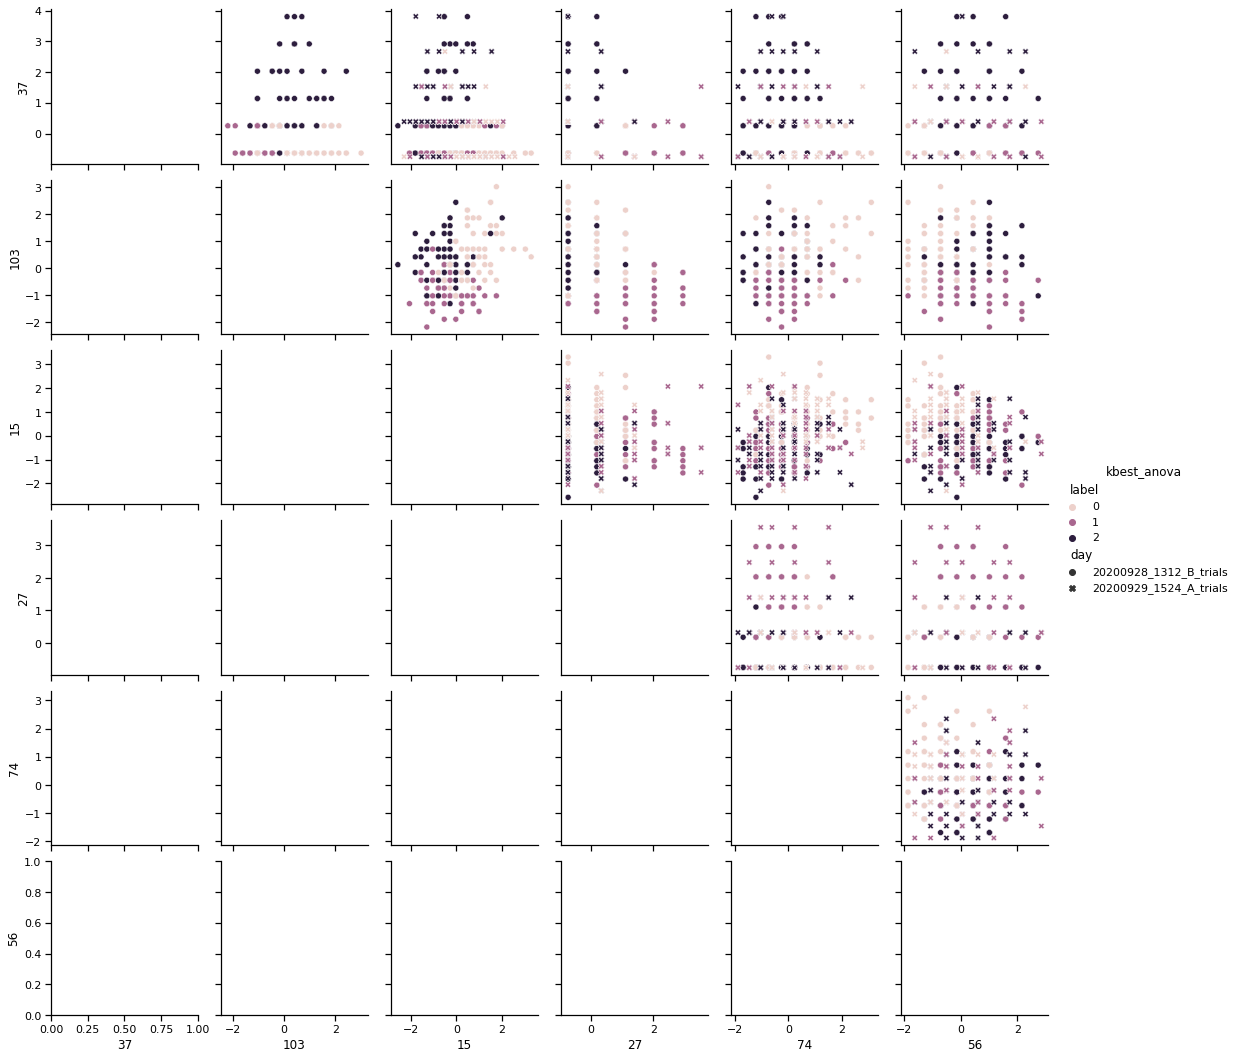

In [15]:
title = step.split("__")[-1]
components_pairplot(
    df_preprocessing[df_preprocessing.split=="train"], 
    cols_to_use,
    title=title,
    with_test=True,
    style_col="day",
    main_split= day
)

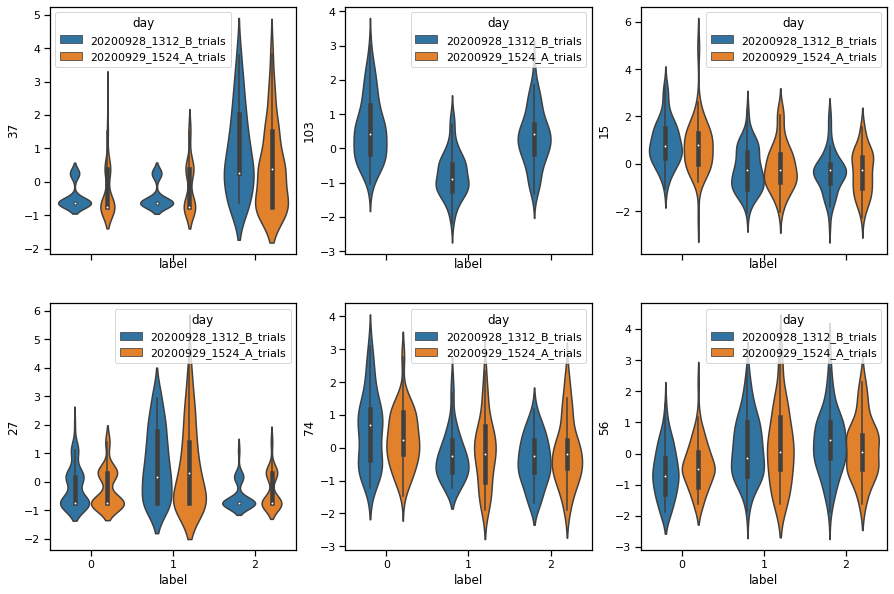

In [16]:
components_violinplot(df_preprocessing, cols_to_use, with_test = True, hue="day")

# Day 2

In [17]:
day = 1
cols_to_use = exp_pipes[day].get_selector_topk(k)

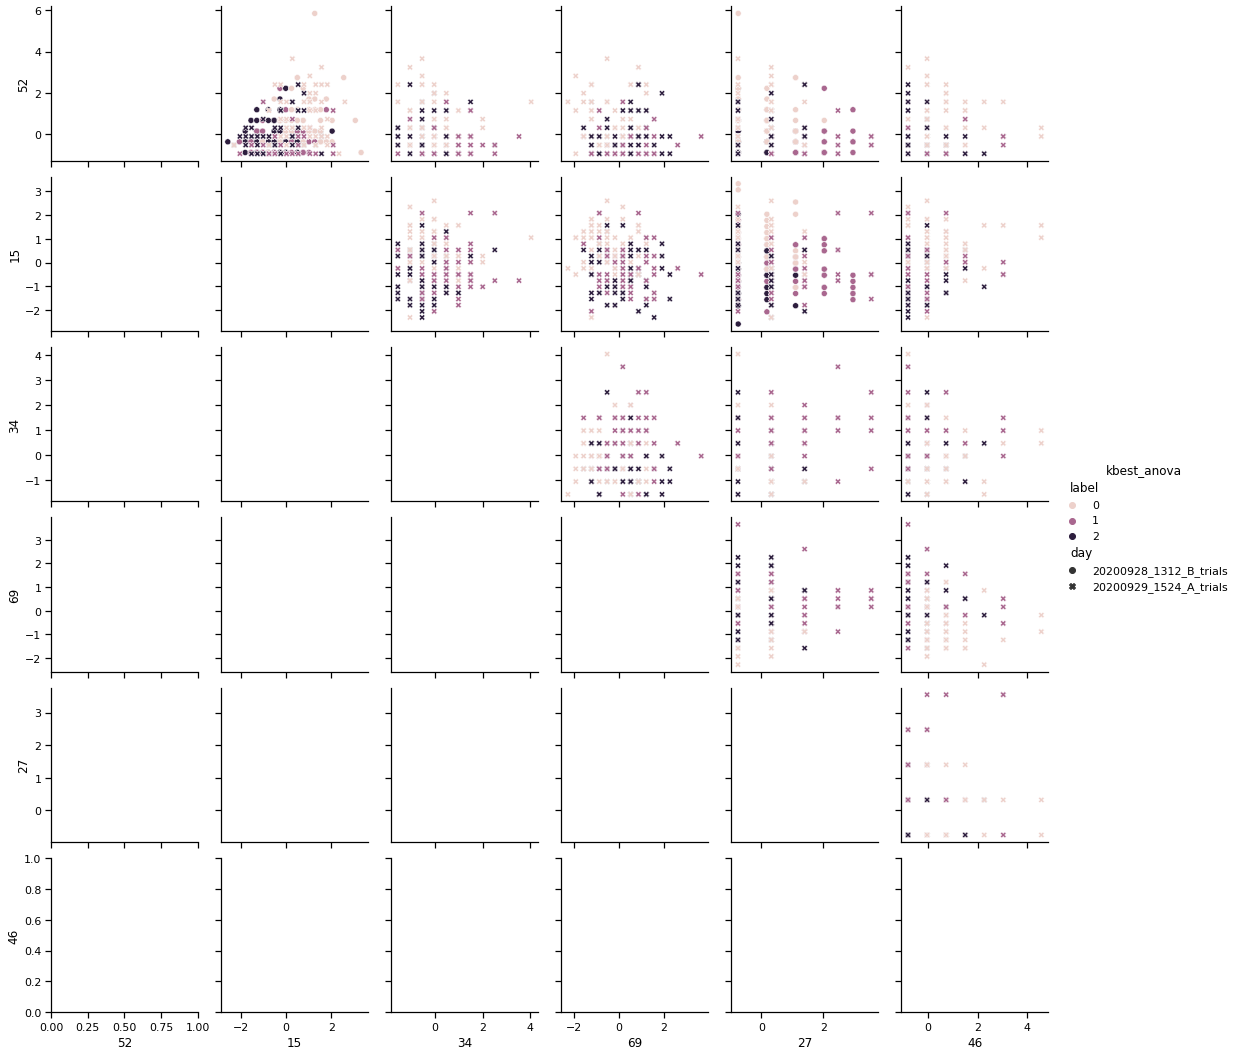

In [18]:
title = step.split("__")[-1]
components_pairplot(
    df_preprocessing[df_preprocessing.split=="train"], 
    cols_to_use,
    title=title,
    with_test=True,
    style_col="day",
    main_split= day
)

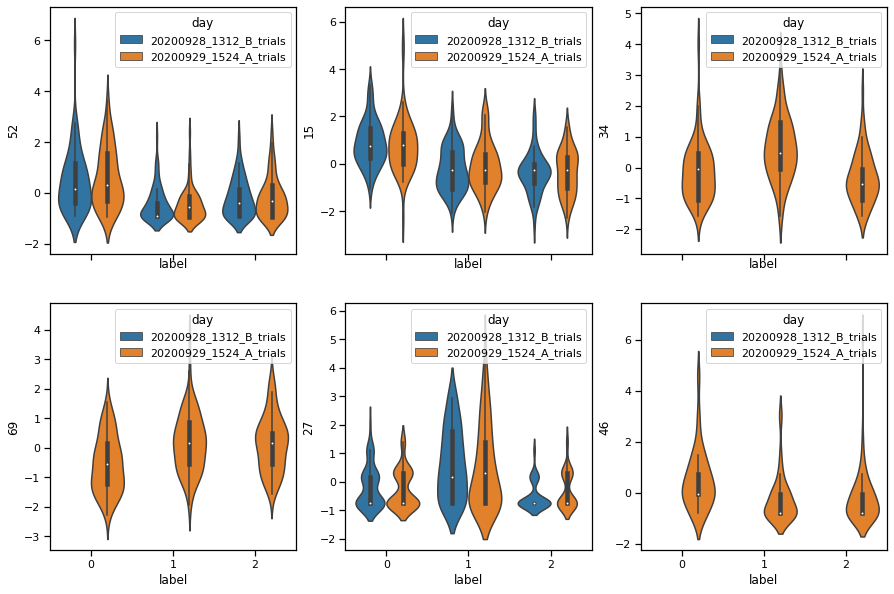

In [19]:
components_violinplot(df_preprocessing, cols_to_use, with_test = True, hue="day")

# Feature Extraction

In [20]:
fe_steps = [f"feature_extraction__{step}"
            for step in pipeline_arch.feature_extraction]

In [21]:
fe_dfs = []

for step in fe_steps:
    step_dfs=[]
    for day, exp_pipe in zip(data.keys(), exp_pipes):
        step_dfs.append(exp_pipe.processed_data_df(step))
    fe_dfs.append(pd.concat(step_dfs).reset_index(drop=True))
    

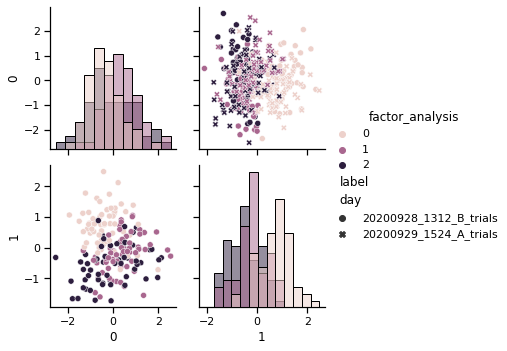

In [22]:
for df, step in zip(fe_dfs, fe_steps):
    title = step.split("__")[-1]
    cols = col_filter(df,k)
    components_pairplot(
        df[df.split=="train"], 
        cols,
        title=title,
        with_test=True,
        style_col="day",
        main_split= day

    )

# Visualize Embeddings (Separate Case)

In [23]:
df = fe_dfs[0]

In [24]:
n_features = step_nfeatures(df)
embedder_model = FEATURE_EXTRACTORS[embedder]

In [25]:
embeddings_dfs = []
for day in data.keys():
    day_df = df[df.day==day].reset_index(drop=True)
    embedding_df = get_embeddings_df(day_df, embedder_model, n_features)
    embeddings_dfs.append(embedding_df)
embeddings_df = pd.concat(embeddings_dfs).reset_index(drop=True)

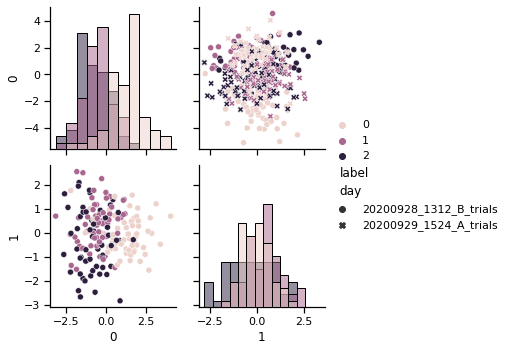

In [26]:
cols_to_use = col_filter(embeddings_df, k)
components_pairplot(
    embeddings_df[embeddings_df.split=="train"],
    cols_to_use,
    with_test=True,
    style_col="day",
    main_split=day
)

# Visualize embeddings (Common case)

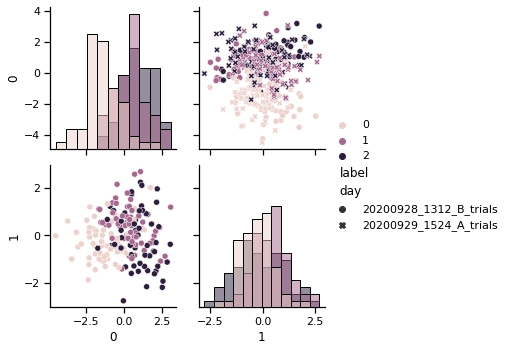

In [27]:
n_features = step_nfeatures(df)
embedder_model = FEATURE_EXTRACTORS[embedder]

for df, step in zip(fe_dfs, fe_steps):
    embeddings_df = get_embeddings_df(df, embedder_model, n_features)
    cols_to_use = col_filter(embeddings_df, k)
    components_pairplot( 
        embeddings_df[embeddings_df.split=="train"],
        cols_to_use,
        with_test=True,
        style_col="day",
        main_split=day
    )


# CCA Plots

In [28]:
# Single steps
data = model._single_transforms(data, single_model, splits)
# Align manifolds
data = model.merge_data(data, splits)

aligner_model = aligner_model.fit(data["train"]["X"])

for split in splits:
    projections = aligner_model.transform(data[split]["X"])
    data[split]["X"] = np.vstack(projections)
    data[split]["y"] = np.concatenate(data[split]["y"])

In [29]:
X = np.vstack([data[split]["X"] for split in splits])

In [30]:
df = pd.DataFrame(X)
df["split"] = np.concatenate(
                [[split] * len(split_dict["y"])
                 for split, split_dict in data.items()]
            )
df["label"] = np.concatenate(
                [split_dict["y"] for split_dict in data.values()]
            )

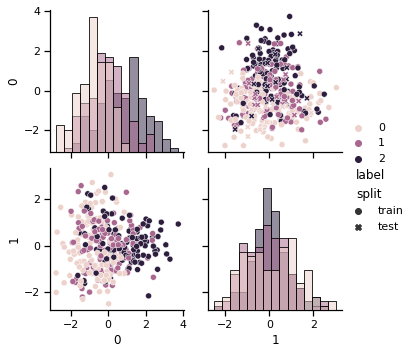

In [31]:
visualize_embeddings(df,"s",embedder,k)